# Setup for Global Explanations slides

* Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn import tree

from collections import defaultdict
from IPython.display import HTML

shap.initjs()
np.random.seed(1)

## Reminder: What is a Global Explanation?

* Explains the **overall** model behaviour
* Approaches:
    * Feature attribution: "*What features of the data is the model generally relying on?*"
    * Model distillation: "*What is a simplified version of our model that is interpretable by a human?*"
* We will focus on **feature attribution** today


We begin with a reminder of what a global explanation is. A global explanation explains overall model behaviour (rather than for one particular instance). There are multiple approaches to explaining global behaviour, including "what features of the data is the model generally relying on (which we call feature attribution) and "what is a simplified version of our model that is interpretable by a human?" (model distillation). In this session we will focus on feature attribution, so we are focusing on how to peer into the black-box model to tease out which features the model is using overall.

## Motivating Example: Breast Cancer Dataset

The Wicsonsin Diagnosis Breast Cancer Dataset (WDBCD) consists of 569 samples of breast tissue, each of which has been labelled as *malignant* or *benign*. For each sample, there are 30 attributes.

In [ ]:
# load breast cancer dataset from sklearn
dataset = load_breast_cancer()

# the dataset is automatically loaded from sklearn in the form of a dictionary of numpy arrays 
# see this by running print(dataset)
print('Target names: ', dataset['target_names']) # or print(dataset.target_names) 
print('Feature names: ', dataset['feature_names']) # or print(dataset.feature_names) 
print('Number of samples: ', dataset['data'].shape[0])
print('Number of attributes: ', dataset['data'].shape[1]) # or print(len(dataset['feature_names']))

# class imbalance
print('Proportion of class 1 labels: ', sum(dataset['target'])/len(dataset['target']))

# labels conversion
print('Labels conversion: [0, 1] --> ', dataset['target_names']) # can confirm this in the sklearn docs

# convert data to pandas df as it is easier to work with pandas in SHAP
X_df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y_df = pd.Series(dataset['target'])

In [ ]:
X_df.head()

We begin with a motivating example, and introduce the Wisconsin Diagnosis Breast Cancer Dataset which can be found [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). This dataset contains 569 samples of breast cancer tissue. Each sample has 30 attributes (measurements) which are the features in our classifier. This is a binary classification task, where we are predicting whether a tumour is malignant or benign. The first 5 samples of the dataset are displayed in the table. 

The code snippets process and explore the data, and convert it into a pandas dataframe.

## Motivating Example: Feature Description

* Features computed from an image of the cells from breast mass
* They describe characteristics of the **cell nuclei** present in the image

| Feature          | Description                                              |
|------------------|----------------------------------------------------------|
| Mean radius      | Mean of distances from centre to points on the perimeter |
| Mean perimeter     | Mean average of the nuclei perimeters                   |
| Mean area        | Mean area of the nuclei                                   |
| Mean smoothness  | Mean of the local variation in radius lengths            |
| Mean concave points | Mean number of concave portions of the contour                |
| Worst radius     | Largest mean distance from centre to points on the perimeter  |
| Worst perimeter    | Largest value of the nucleus perimeter                    |
| ...              | ...                                                      |

To familiarise ourselves with the data, we look in more detail about what the different features are. The features are computed from a digitised image of a fine needle aspirate of a breast mass. They describe characteristics of the cell nuclei present in the image. A few of the features are described in the table. Note that the mean average values and the worst (largest) values are reported as separate features, for a range of measurements. Multiple cells are in each image, which is why we can have a "largest mean distance" - we take the mean distance for each cell and then compute the largest of those values.

## Motivating Example: Train Model

A **random forest** classifier was trained on the WDBCD training data.

* The model is extremely difficult to interpret: it is **black-box**
* 5 of the 100 trees in the random forest are shown below - it is very complex!
* But it gives us good test accuracy...

In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, random_state=42)

# train random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(rf.score(X_test, y_test)))

In [ ]:
# plot 5 trees from our random forest model
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (15,3), dpi=900)
for index in range(0, 5):
    tree.plot_tree(rf.estimators_[index],
                   feature_names = dataset.feature_names, 
                   class_names=dataset.target_names,
                   filled = True,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 8)
plt.plot()
plt.show()

We first split the data into training and test sets, and train a random forest model which achieves 97% accuracy on the test set. This random forest consists of 100 tree-based estimators, which makes it a black-box model. The figure shows 5 of the 100 trees that make up the model. We cannot interpret this! So need global explanation methods...

## Why Do We Need Explanations?

Suppose an oncologist is interested in using our random forest classifier as an additional diagnostic tool. She needs convincing that our model is using sensible attributes to make its decisions.
* The random forest is too complex for the oncologist (or anyone!) to interpret directly
* We need to use a **global explanation method** to explain the overall behaviour of the model

Let's see some in action!


## Overview

We will cover two **feature attribution** global explanation methods:
1. Permutation Feature Importance
    * Intuition and theory
    * Example on the breast cancer data
2. SHAP (SHapley Additive exPlanations)
    * Theory of Shapley values
    * Intuition and theory
    * Using SHAP for global and local explanations
    * Example on the breast cancer data

In the remainder of the session we will cover two feature attribution explanations. The first is permutation feature importance and the second is SHAP. SHAP is both a global and local explanation, so we will have a quick flavour of local explanations too. We will cover the intuition and theory for both methods, as well as generate explanations for the breast cancer classifier. 

## Permutation Feature Importance: Intuition

* Global: "*What features of the data is the model generally relying on?*"
* Choose a feature to compute importance score for
* Randomly shuffle the values in that column
* Observe the effect on the model performance before and after shuffling: if the effect is large, this feature is deemed *important*
* Details of algorithm can be found [here](https://deepai.org/publication/model-class-reliance-variable-importance-measures-for-any-machine-learning-model-class-from-the-rashomon-perspective)

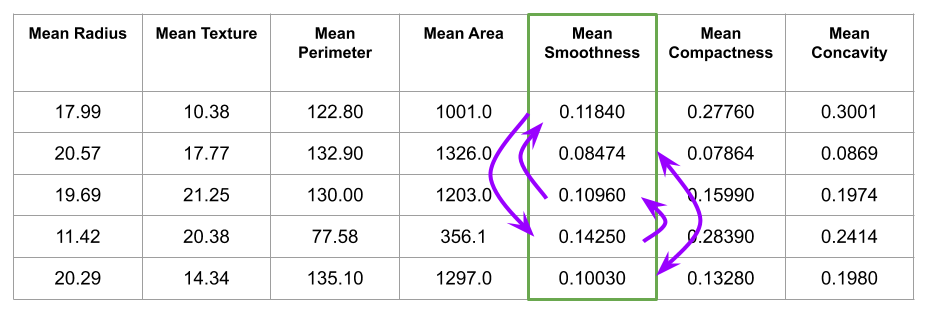

The main idea behind permutation feature importance is intuitive. It answers the question "*What features of the data is the model generally relying on?*" (a global method), and produces an importance score for each of the features in the model. It works as follows. Choose a feature to compute importance score for: in this case "mean smoothness". Then randomly shuffle the values in that column only. We then observe the effect on the model performance before and after shuffling. If the effect is large (so we see a big change in model performance), this feature is deemed *important* and will achieve a high importance score.

Extra notes on the details of the permutation feature importance algorithm (for those who are interested):

_Permutation Feature Importance: Algorithm_

Inputs: trained model $f(x)$, train or test set features $X \in \mathbb{R}^{n \times p}$, corresponding test set labels $\mathbf{y} \in \mathbb{R}^n $, error function $L(\mathbf{y}, f(x))$

1. Compute the initial error on the test set before any permutations: $e_0 = L(\mathbf{y}, f(X))$
2. For each feature $j = 1, 2, \ldots, p$:
    1. Generate a new feature matrix $\tilde X_j$ by randomly permuting the values of feature $j$ in the data $X$
    2. Compute the error on the permuted feature matrix: $e_j = L(\mathbf{y}, f(\tilde X_j))$
    3. Compute the permutation feature importance score: $I_j = e_j - e_0$
3. Sort features by descending order of $I$

We take an already trained model $f(x)$, some train or test data $X$ (it is unclear which is best to do), the corresponding test set labels, and an error (or loss) function - perhaps this a loss function that measures how many errors our model makes. The first step is to compute the initial error on the test set before we do any permutations. This acts as our baseline. Then, for each feature in turn, we generate a new feature matrix ($\tilde X_j$) by randomly shuffling the values of feature $j$ in the data $X$. We then compute the error on the permuted feature matrix, and then compute the change in error to get the feature importance score. After we have done this for all features, we sort the features by descending order of importance. So the features with the highest feature importance score lead to the largest increase of error when the column is shuffled.

## Permutation Feature Importance: Advantages

* Fast to calculate
* Works with classification and regression models
* Gives very compressed representation of the model
* Post-hoc, model agnostic method
* Python packages exist for easy implementation: we will use $\texttt{sklearn.inspection}$ library, but others exist too (e.g. $\texttt{eli5}$)

Permutation feature importance works with both classification and regression models. Advantages of the method are that it is fast to calculate and is a post-hoc, model agnostic method. It works after we have trained the model and we can choose any type of model we like. In this lesson we use the sklearn.inspection python package, but others also exist too (e.g. eli5).

## Permutation Feature Importance: Words of Warning

* Randomness in the shuffling can lead to **variation** in results - repeating the algorithm multiple times and taking an average can help
* Unclear whether to use the training or test set: see "[Interpretable ML](https://christophm.github.io/interpretable-ml-book/feature-importance.html#feature-importance-data)" book by Christoph Molnar
* Permutation Feature Importance does not deal with **correlated features** very well
    * Random shuffling could lead to unrealistic samples, e.g. height of 2m and weight of 40kg
    * Correlated features could see a decrease in importance due to the importance being "split" between them
    * If appropriate: cluster features that are correlated and only keep one feature from each cluster
* Features that are not deemed important for a bad model could be **very important** for a good model

There are some important points to raise regarding the limitations of permutation feature importance. Randomness in the shuffling part of the algorithm can lead to variation in the obtained results. For example, we could repeat the analysis and, just because we happened to shuffle the column in a different way, we would yield a different score. A quick remedy for this is to repeat the algorithm multiple times to reduce random variation.

It is unclear whether to use the training or test set to compute importance scores. There are arguments for both: see ["Interpretable ML"](https://christophm.github.io/interpretable-ml-book/feature-importance.html#feature-importance-data) book by Christoph Molnar who makes the cases for each.

Also, Permutation Feature Importance does not deal with correlated features very well. There are two reasons for this. Randomly shuffling one column could lead to unrealistic data instances, e.g. somebody with height of 2m and weight of 40kg, which the model doesn't know how to deal with very well - it hasn't been trained on data from this distribution. Secondly, correlated features could see a decrease in importance due to the importance being "split" between them. A potential remedy (though not always appropriate) is to cluster features that are correlated and only keep one feature from each cluster.

Finally, features that are not deemed important for a bad model could be very important for a good model. Permutation Feature Importance does not reflect the intrinsic predictive value of a feature by itself but how important this feature is for a particular model. It is always important to evaluate the predictive power of a model using a test set prior to computing importances.

## Permutation Feature Importance: Result on WDBCD

* Box-plots show the feature importance (over 20 repetitions) on the training data
* Results are not robust: try the code with different random states
* Accuracy changes by at most 0.012 for any feature, which is very small
* We may need to do further work to account for the correlated features

In [ ]:
# use sklearn's model agnostic permutation_importance function 
result = permutation_importance(rf, X_train, y_train, n_repeats=20, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X_train.columns[perm_sorted_idx])
ax1.set_xlabel('Permuntation Feature Importance Score')
fig.tight_layout()
plt.show()

When we run permutation feature importance on our random forest model, we get the following results. To try to remove some random variation, we repeat the permutation feature importance algorithm 20 times. This generates 20 importance scores per feature which are what the box-plots are displaying. This plot is computed on the training data, though as mentioned previously it is unclear with permutation feature importance whether it is best done on the training or test data. The results are not robust: try the code with different random states and see how it affects the plot. It is likely due to the fact that the accuracy changes by at most 0.012 for any feature, which is very small. And there seems to be a lot of statistical variation in the shuffling, as seen by the wide boxes in the box plots. We may need to do further work to account for the correlated features (see bonus section of practical). 

### Permutation Feature Importance Practical

Open up the practical and have a go implementing permutation feature importance for yourself! 

## SHAP (SHapley Additive exPlanations)

* Can generate **global** *and* **local** explanations - we will see both!
    * Global: "*What features of the data is the model generally relying on?*"
    * Local: "*What features of the data is the model relying on for a particular sample?*"

* Uses **Shapley Values** to generate the explanations
    * Game theory: "*Given a set of players with different skillsets playing a game and winning a prize, what is a fair way to distribute the winnings according to their individual contribution?*"
    * Shapley Values measure the contribution of each player in the game (feature in the ML model)

We now move onto the next explanation method - SHAP, which stands for Shapley Additive Explanations. SHAP can produce both global and local explanations. In fact, the global explanation in this case is created from an average of local explanations! So we will cover both SHAP for global and local explanations. They are both feature attribution methods, so the global explanation addresses the question "What features of the data is the model generally relying on?" and the local explanation addresses the question "What features of the data is the model relying on for a particular sample?". 

There is a clue in the name - SHAP is based on something called a Shapley Value. While SHAP explanations have only been around since 2016, Shapley values have been around since 1951. The concept comes from game theory and was traditionally applied in economics. Shapley Values measure the contribution of players in a game. In particular, they allow us to answer the question "Given a set of players with different skillsets playing a game and winning a prize, what is a fair way to distribute the winnings according to their individual contribution?". Shapley Values measure the contribution of each player in the game. For our ML model, the players in the game are the features and we want to know the contribution of each feature to the model's decisions.

## Shapley Values Example

* Suppose a combination of players with different skillsets play a game, in which they earn a prize $y$
* The winnings $y$ depend on which players join the team: some players work better with each other than others
* We wish to know: "*How much does Mastermind contribute to the team?*"

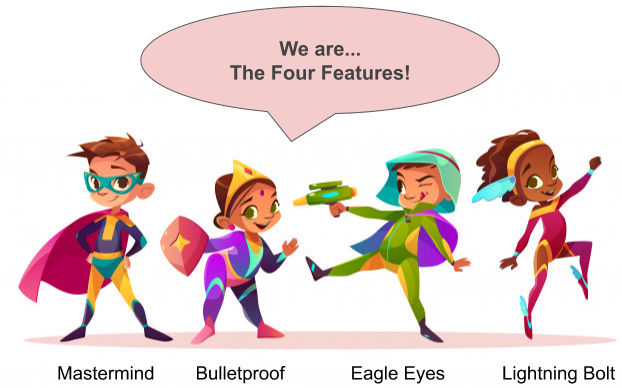

We begin with an example of Shapley values to gain some intuition. Suppose we have players with different skillsets - we have a team of 4 superheroes, each of which has a different speciality. Some - or all - of the players can form a team and play a game. When they play the game, they earn a prize which we denote by the random variable $y$. The amount they win depends on which players join the team: some players work better with each other than others. For example, when Mastermind and Bulletproof are on the team together, they work exceptionally well to devise a perfect defence strategy. But if Eagle Eyes also joins, he likes to takeover and has a very different approach to defence. We wish to know: "*How much does Mastermind contribute to the team?*". This is equivalent to finding the Shapley Value of Mastermind.

## Shapley Values Example

* Let $N$ denote the set of players, $n$ the number of players, and $S$ denote a particular combination of the players (a coalition) 
    * $N = \{M, B, EE, LB\}$ and $n=4$
    * One possible coalition: $S = \{B, LB\}$
* Suppose we can simulate the winnings $y(S)$ for all different coalitions $S$:
    * Examples: $y(M, B, EE, LB) = 17$ and $y(M) = 2$
* We can compute the difference in winnings, the **marginal contributions**, when Mastermind is excluded from the team:
    * $(y(S \cup \{M\}) - y(S))$ for coalitions $S$ that *exclude* Mastermind $S \subseteq N \backslash \{M\}$ 
* Mastermind's Shapley Value is a **weighted average** of **all the marginal contributions**:
    * $\varphi_{M}=\sum_{S \subseteq N \backslash\{M\}} \frac{|S| !(n-|S|-1) !}{n !}(y(S \cup\{M\})-y(S))$
* Repeat the process for each player to get their Shapley Values

To compute the Shapley value of Mastermind, we need to look at how adding Mastermind to different combinations of players in the team changes the winnings they earn. We introduce some notation: capital $N$ is the set of players, $n$ is the number of players and $S$ denotes a particular combination - or subset - of the players, which we call a coalition. In our example, $N$ is the set of Mastermind, Bulletproof, Eagle Eyes and Lightning Bolt. There are 4 players in total. One possible coalition is Bulletproof and Lightning Bolt, but of course there are many combinations ($2^4$). 

We need to suppose we can simulate the winnings of the game for different teams we can create. For example, we have a function to tell us that if Mastermind, Bulletproof, Eagle Eyes and Lightning Bolt were all on the team, the winnings would be 17. If only Mastermind was on the team, the winnings would be 2. If nobody was on the team, the winnings would be 0. And so on.

We then look at the difference in winnings when Mastermind is and isn't on the team for different coalitions - these differences are called the marginal contributions. The formula for the marginal contribution for a particular coalition $S$ that does NOT contain mastermind is $(y(S \cup \{M\}) - y(S))$ - the winnings when Mastermind is added to the team minus the winnings when he wasn't on the team.

The Shapley value for Mastermind is the weighted average of his marginal contributions when considering all coalitions. Don't worry too much about the complicated-looking term at the beginning of the sum - that is a number that represents the weights in our average. Details of why this is there can be found in the literature (the original SHAP paper is included in the additional materials). But all we really need to know is that the Shapley Value computes the marginal contributions of Mastermind to all possible coalitions, and then takes a weighted sum (average) of these.

## Shapley Values for Feature Importance

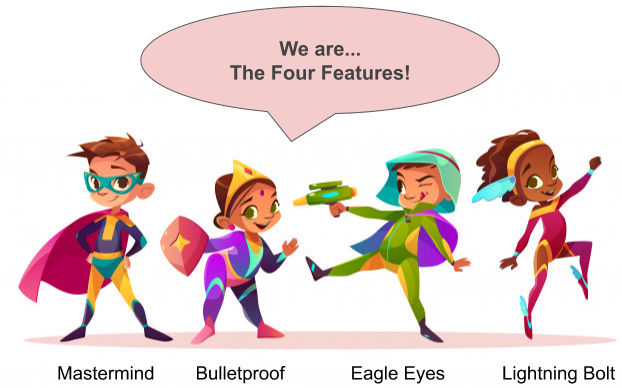

In a machine learning setting:
* We compute a Shapley value for each feature (our features are the "players")
* The model output (probability for classification and value for regression) represents the "winnings" of the game
* Let's think about how to compute the marginal contributions for features...


So how do we transfer this idea to a machine learning setting? It isn't the most inspiring team name but it sums it up well - the players in the team are the four features of our ML model! 

In a ML setting, we compute a Shapley value for each feature (our features are the "players"). The model output (probability for classification and value for regression) represents the "winnings" of the game. It's not so obvious how we compute marginal contributions of features, because we cannot exclude features from a model very easily. So we need to think about this, and we now move onto an example using a simple regression model.

## Computing Marginal Contributions for Features: Example

* Suppose we have a model $y = f(x)$ for predicting the price $y$ of a house $x$
* The features are: number of bedrooms ($x_1$), floor area ($x_2$), and whether or not it has a garden ($x_3$)
* In our training data, the average price of all houses is £250,000
* Consider a new house that is about to go on the market: before we know anything about the house, our best guess at its value is £250,000
* Our prediction updates as we find out more information about the house:
 
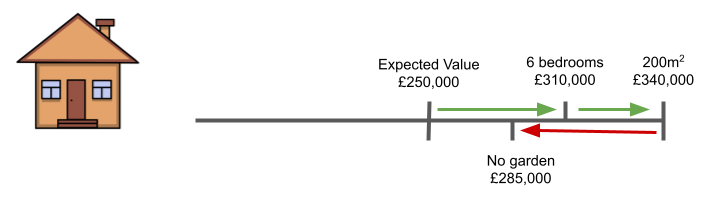

We consider another example now - this time looking at how to compute marginal contributions for features. Suppose we have a model $y = f(x)$ for predicting the price $y$ of a house $x$. The features are: number of bedrooms (denoted by $x_1$), floor area (denoted by $x_2$), and whether or not it has a garden (denoted by $x_3$).

As with all models we train, we have some training data. The average price of all houses in the training data is £250,000, regardless of how many bedrooms they have, their floorspace or whether they have a garden.

We now consider a new house that is about to go on the market: before we know anything about the house, our best guess at the price would be £250,000 - the average price we observed in the training data. But as we incrementally find out more information about the house, we can update the predictions.

For example, suppose we find out the house has 6 bedrooms. We can now update our prediction by computing the price our model predicts for all 6 bedroom houses, but with the other features averaged. Then we find out the house has 200$m^2$ of floorspace, and the prediction rises again to £340,000. Finally we find out the house has no garden and this decreases the valuation to £285,000. 

If we were to plug in all the information at once to our model, we would get the final valuation £285,000. But by doing it incrementally like this we are able to see how the different features affect the model outcome.

## Computing Marginal Contributions for Features: Example

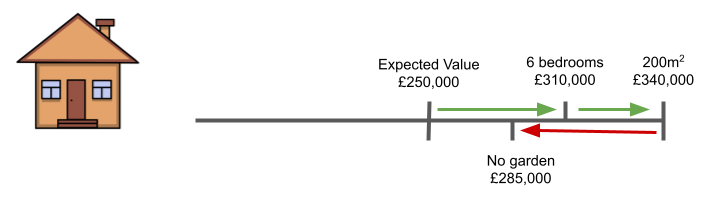

Where do the updated model predictions come from?
* Deal with "missing" features in the model by using the mean value $E[x]$
* Compute the model predictions for the different stages:

    * $f(x_1 = E[x_1], x_2 = E[x_2], x_3 = E[x_3]) = 250,000$

    * $f(x_1 = 6, x_2 = E[x_2], x_3 = E[x_3]) = 310,000$

    * $f(x_1 = 6, x_2 = 200, x_3 = E[x_3]) = 340,000$
    
    * $f(x_1 = 6, x_2 = 200, x_3 = 0) = 285,000$

We formalise this idea now. We deal with the "missing" features of our model by substituting the missing feature with the mean value of that feature - the expectation. This is an approximation based on some assumptions, and more details can be found in the original SHAP paper included in the additional materials.

In our example, before we know any information we substitute the values $x_1, x_2$ and $x_3$ by their respective averages from the training data. Plugging that into the model gives £250,000. Then when we find out the number of bedrooms, we can substitute this value in for $x_1$ and so on...

## Computing Marginal Contributions for Features: Example
 
* The **marginal contributions** for $x_1$ *for this house* are:

 * $f(x_1 = 6, x_2 = E[x_2], x_3=E[x_3]) - f(x_1=E[x_1], x_2=E[x_2], x_3=E[x_3])$   

 * $f(x_1=6, x_2=200, x_3=E[x_3]) - f(x_1=E[x_1], x_2=200, x_3=E[x_3])$  

 * $f(x_1=6, x_2=E[x_2], x_3=0) - f(x_1=E[x_1], x_2=E[x_2], x_3=0)$

 * $f(x_1=6, x_2=200, x_3=0) - f(x_1=E[x_1], x_2=200, x_3=0)$
 
* We can plug these into the Shapley Value formula to get the **local** Shapley value for this particular house
* Repeat this for all houses and take an average of the magnitude of the local Shapley values to get the **global** Shapley Value

The marginal contributions for $x_1$ for this particular house are as follows. We look at the difference in the model prediction when $x_1$ is included versus when the average value of $x_1$ is used instead.

We can plug these marginal contributions into the Shapley value formula (the weighted average) to get the local Shapley value of $x_1$ for this particular house. Importantly, we have used information about this house such as that the floorspace is $200m^2$ and so on, so the value we get for this Shapley value is specific to this sample (the house). This is what makes it a local explanation.

We repeat this process for all houses in the data and then we can take an average of the magnitudes of all the Shapley values for feature $x_1$ across the different samples, to get the global Shapley value which will make up our global explanation.

## SHAP: Algorithm

* Inputs: trained model $f(x)$ and test data $X \in \mathbb{R}^{n \times p}$. 
* Notation: let $S$ be the set of feature values that are included in the model (rather than substituting for the expected value) and $P$ is the set of all features
 
1. For each sample $i = 1,2,\ldots,n$:
    1. For each feature $j=1,2,\ldots,p$:
        1. Compute the weighted average of the marginal contributions to get the Shapley Value $\varphi_{ij}$ for sample $i$ and feature $j$:
            $$\varphi_{ij}=\sum_{S \subseteq P \backslash\{x_{ij}\}} \frac{|S| !(p-|S|-1) !}{p !}(f(S \cup\{x_{ij}\})-f(S))$$
    2. The Shapley Values $\{\varphi_{i1}, \varphi_{i2}, \ldots, \varphi_{ip}\}$ give the **local SHAP explanation** for sample $i$ 
2. To compute the **global SHAP explanation**, for each feature $j=1,2,\ldots,p$:
    1. Compute the average of the magnitude of the local Shapley Values $\varphi_j = \frac{1}{n}\sum_{i=1}^n |\varphi_{ij}|$ 

We now look at the formal algorithm for SHAP for feature importance.

We input a trained model $f(x)$, and some test data $X$. The test data contains $n$ samples and $p$ features. Note that we do not need the true labels here. Here, $S$, the coalition, represents which features are "included" - this means that we use the actual observed value $x_{ij}$ rather than substituting in the average value $E[x_j]$. The set of features $\{x_1, x_2, \ldots, x_p\}$ is denoted by $P$. 

For each sample $i$, and for each feature $j$, we first compute the marginal contributions for feature $x_j$. This is the difference between the model output when the true value of $x_{ij}$ is included versus when it is substituted for the expected value. We have $p$ featuers and can use the Shapley value formula as before.

After we have done that for each feature for our sample $i$, we have a set of Shapley values $\{\varphi_{i1}, \varphi_{i2}, \ldots, \varphi_{ip}\}$ that gives us the local SHAP explanation for sample $i$. After we have repeated this for all samples in the dataset, we can compute the global SHAP explanation. To do this, for each feature $j=1,2,\ldots,p$ we compute the average of the magnitude of the local Shapley Values $\varphi_j = \frac{1}{n}\sum_{i=1}^n |\varphi_{ij}|$.

## SHAP: Implementation

* Used with classification or regression models
* Post-hoc, model agnostic method
* We will use the $\texttt{shap}$ Python package
* Simulating all combinations of features is computationally expensive, so there exist multiple methods for approximating SHAP values depending on the model used:
    * TreeExplainer: for tree based models such as random forest, LightGBM, XGBoost...
    * DeepExplainer: for deep learning models
    * KernelExplainer: model agnostic (works with all models, but is slower)

Luckily for us there are python packages which do this algorithm behind the scenes! SHAP can be used with classification or regression models (for a classification model the model output is the class probabilities). It is a post-hoc, model agnostic method so can be used with a ready trained model of any type. We will use the $\texttt{shap}$ Python package in this lesson. Simulating all combinations of features is computationally expensive, so there exist multiple methods for approximating SHAP values depending on the model used. TreeExplainer: for tree based models such as random forest, LightGBM, XGBoost... DeepExplainer: for deep learning models and KernelExplainer: model agnostic (works with all models, but is slower).

## Local SHAP: Example on Wisconsin Diagnosis Breast Cancer Dataset

* Choose one patient from the test set to generate the **local** explanation
* Base value is the the proportion of benign tumours in our training data
* Output value $f(x)$ is the model prediction for this patient (the probability of a benign tumour for this particular patient)
* In red are the positive SHAP values that increase the probability of the tumour being benign, and in blue are the negative SHAP values that decrease the probability of the tumour being benign

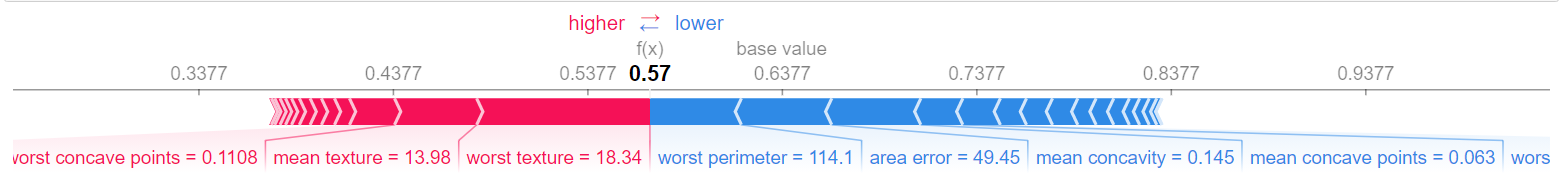

In [ ]:
# create the shap explainer
shap_explainer = shap.TreeExplainer(rf, X_train) # choose TreeExplainer because we have a tree based model (random forest)
shap_values = shap_explainer.shap_values(X_test) # compute shap values on test set
base_value = shap_explainer.expected_value[1] # gives the base value (expected value for outcome - equivalent to the expected probability of class 1 for binary classification)

In [ ]:
# Code to generate the image below
shap.initjs() # to visualise the shap plots
shap.force_plot(base_value, shap_values[0,:,1], X_test.iloc[0,:]) # shap_values has a shape of (143, 30, 2) -> (rows, features, class)

Now we are familiar with SHAP, we go back to the Wisconsin breast cancer dataset and our random forest model to see it in action. We begin with a local SHAP explanation for a particular patient. This is equivalent to choosing one particular value of $i$ in the SHAP algorithm slide and just stopping at the local explanation step (step 1B). 

The base value (as written in the explanation) is the the proportion of benign tumours (class 1) in our training data - it is equivalent to the £250,000 figure for the house prices example. The output value $f(x)$ is the model prediction for this patient (the probability of a benign tumour for this particular patient). In red are the positive SHAP values that increase the probability of the tumour being benign, and in blue are the negative SHAP values that decrease the probability of the tumour being benign. For example we see the worst texture being 18.34 has a large positive effect on the tumour being benign.

## Global SHAP: Example on Wicsonsin Diagnosis Breast Cancer Dataset

* Plot local Shapley Values for each point in the test set
* A low value of "worst perimeter" has a positive impact on the model output (increases the probability of tumour being benign)

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_test)

Once we have computed all the local Shapley values, we can plot them together in a scatter plot. Here, each dot represents a different patient in the test set. The colour (red versus blue) tells us whether a high or low feature value causes the difference in model outcome. For example, looking at the "worst perimeter" Shapley values, we see that a smaller value (blue) has a positive impact on the model output (increases the probability of tumour being benign - class 1). We can see that there are two interesting clusters in the "worst perimeter" row: a red cluster on the left and a blue cluster on the right. This tells us that high values of "worst perimeter" (red) - suggesting a larger tumour - have a negative impact on the model output in general. Since our model output is the probability of class 1 (benign tumour) then if a tumour has a larger "worst perimeter", it decreases the probability of a tumour being benign (i.e. increases the probability of it being malignant).

## Global SHAP: Example on Wicsonsin Diagnosis Breast Cancer Dataset

* Compute the **global** SHAP explanation by taking an average of the magnitude of the Shapley Values for all patients in the test set

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_test, plot_type='bar')

Finally, we can compute the mean of the magnitude of those SHAP values displayed in the scatter plot to get a bar chart of the mean size of the SHAP values over the test data. This gives us our global explanation. The reason we use the magnitude is to take the average of the model impact (positive or negative). For example, in the previous slide, the SHAP values for "worst perimeter" were often far from zero, but because some were positive and some were negative, taking the mean value of the raw values would not capture this spread away from zero.

## SHAP: A Small Word of Warning

* While SHAP is a more sophisticated way of measuring feature attribution than Permutation Feature Importance, it is not perfect
* Emerging research shows that it is possible to create intentionally misleading interpretations with SHAP, which can hide biases:
    * ["Fooling LIME and SHAP: Adversarial Attacks on Post hoc Explanation Methods", Slack et. al, 2020.](https://arxiv.org/pdf/1911.02508.pdf)
* If you are the data scientist creating the explanations, this is not an actual problem, but it is a disadvantage as the receiver of an explanation, as you can be less sure about its truthfulness

While SHAP is a more sophisticated way of measuring feature attribution than Permutation Feature Importance, it is not perfect and we have to be careful not to treat the explanation as ground truth. Emerging research shows that it is possible to create intentionally misleading interpretations with SHAP, which can hide biases - see the paper ["Fooling LIME and SHAP: Adversarial Attacks on Post hoc Explanation Methods", Slack et. al, 2020.](https://arxiv.org/pdf/1911.02508.pdf) for more details. If you are the data scientist creating the explanations, this is not an actual problem, but it is a disadvantage as the receiver of an explanation, as you can be less sure about its truthfulness.

## Summary

In this session on global explanations, we covered the following:

* Motivating example of a black-box classifier on the Wisconsin Diagnosis Breast Cancer Dataset
* Permutation Feature Importance method for generating global explanations
    * Intuition
    * Limitations
* SHAP (SHapley Additive exPlanations) for generating global (and local!) explanations:
    * Shapley Values
    * Applying Shapley Values to feature importance

We have reached the end of the global explanations lesson! To summarise, in this session we covered a motivating example of a black-box classifier on the Wisconsin Diagnosis Breast Cancer Dataset. We used a random forest, which contains many trees and is therefore not interpretable to a human. We spoke about how if an algorithm was to be used for a high-stakes decision in practice (for example, the oncologist using the classifier as a diagnostic tool), explanations are vital. We focused on two global explanation methods - Permutation Feature Importance (which has some limitations to be wary of) and SHAP - and spoke about how SHAP, by its nature, can also be used to explain local decisions as well. The theory of SHAP was a little more involved, and is based on the concept of Shapley Values. We covered what Shapley values are (in the context of game theory) and then looked at how to apply Shapley values to feature importance using the house price example. Finally, we looked at local and global SHAP explanations on the breast cancer classifier.